In [1]:
import re
import uuid
import pickle
from unicodedata import normalize
from string import punctuation
import warnings
from concurrent.futures import ProcessPoolExecutor
from multiprocessing import cpu_count
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import spacy
import nltk
from nltk.cluster import KMeansClusterer
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import homogeneity_completeness_v_measure, silhouette_score, davies_bouldin_score
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import MDS, TSNE, LocallyLinearEmbedding, SpectralEmbedding
from sklearn.decomposition import NMF
from sklearn.cluster import DBSCAN, OPTICS, KMeans
import hdbscan
from pyclustering.cluster.xmeans import xmeans, kmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.elbow import elbow
from pyclustering.cluster.silhouette import silhouette_ksearch_type, silhouette_ksearch
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from IPython.display import HTML

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

warnings.filterwarnings('ignore')
np.random.seed(123456)

cpu_max = 4 if cpu_count() >= 4 else cpu_count()

%matplotlib inline

In [2]:
def euclidian(a, b, axis=-1):
    return np.sqrt(np.sum(np.square(a - b), axis=axis))

def make_colors(y_train, cluster_labels, colors):  
    cl_train = colors[:len(set(y_train))]
    cl_cluster = colors[:len(set(cluster_labels))]
    c_y_train = [cl_train[y] if y >= 0 else [0.50196078, 0.50196078, 0.50196078] for y in y_train]
    c_y_cluster = [cl_cluster[y] if y >= 0 else [0.50196078, 0.50196078, 0.50196078] for y in cluster_labels]
    return c_y_train, c_y_cluster

def join_cluster(X, cluster_labels):
    max_cluster_label = np.max(cluster_labels)
    idx = np.where(cluster_labels == -1)
    X_org = X[np.where(cluster_labels != -1)]
    for x in idx[0]:
        sim = np.round(1 - cosine_similarity([X[x]], X_org), 3).ravel()
        dcs = np.where(sim <= 0.6)
        it = 0.65
        while len(dcs[0]) == 0:
            dcs = np.where(sim <= it)
            it += 0.05
        original_label = y_train[dcs[0][0]]
        cluster_labels[idx] = original_label if original_label <= max_cluster_label else max_cluster_label + 1
    return cluster_labels

def remover_acentos(txt):
    return normalize('NFKD', txt).encode('ASCII', 'ignore').decode('ASCII')

def is_number(s):
    try:
        complex(s) # for int, long, float and complex
    except ValueError:
        return False
    return True

def tokenizer(phrase):
    phrase = phrase.lower()
    for o, r in RM:
        phrase = re.sub(o, r, phrase, flags=re.MULTILINE)
    phrase = re.sub(r'["\'@#%\(\)$0-9]', " ", phrase)
    phrase = NLP(re.sub(r'[-+=:]', "", phrase), disable=["parser"])
    clean_frase = []
    for palavra in phrase:
        if palavra.pos_ != "PUNCT":
            word = palavra.text.strip()
            if not is_number(word) and word not in STOPWORDS and len(word) > 1:
                try:
                    word = VERBOS[word]
                except:
                    word = palavra.lemma_
                clean_frase += [remover_acentos(word)]
                # clean_frase += [STEMMER.stem(remover_acentos(palavra.lemma_))]
    return clean_frase

def _get_stopwords():
    stpwords = sorted(list(set(stopwords.words('portuguese') + list(NLP.Defaults.stop_words) + list(punctuation))))
    rms = ["um", "uma", "não", "mais", "muito", "você"]
    for rm in rms:
        del stpwords[stpwords.index(rm)]
    return stpwords

# NLP = spacy.load("pt")
# STEMMER = nltk.stem.RSLPStemmer()
NLP = spacy.load('pt_core_news_sm')
STEMMER = nltk.stem.SnowballStemmer('portuguese')
STOPWORDS = _get_stopwords()
RM = [
    ('\n', '. '), ('"', ''), ('@', ''),
    ('#', ''), ('RT', ''), (r'(http[s]*?:\/\/)+.*[\r\n]*', '')
]

VERBOS = {}
with open("datasets/verbs.pkc", "rb") as infile:
    verbos = pickle.load(infile)
    for verb in verbos:
        for v in list(verb.values())[0]:
            VERBOS[v] = list(verb.keys())[0]
    
colors = np.asarray([
    (230, 25, 75), (60, 180, 75), (255, 225, 25), (0, 130, 200), (245, 130, 48), (145, 30, 180), (70, 240, 240),
    (240, 50, 230), (210, 245, 60), (250, 190, 190), (0, 128, 128), (230, 190, 255), (170, 110, 40), (255, 250, 200),
    (128, 0, 0), (170, 255, 195), (128, 128, 0), (255, 215, 180), (0, 0, 128), (128, 128, 128), (0, 0, 0),
    (141, 204, 226), (212, 50, 147), (251, 226, 93), (16, 185, 176), (189, 182, 163), (244, 172, 18), (100, 28, 112),
    (165, 124, 92), (183, 160, 211), (66, 47, 105), (240, 67, 7), (244, 188, 198),
    
    (249, 235, 234), (242, 215, 213), (230, 176, 170), (217, 136, 128), (205, 97, 85), (192, 57, 43), (169, 50, 38), 
    (146, 43, 33), (123, 36, 28), (100, 30, 22), (253, 237, 236), (250, 219, 216), (245, 183, 177), (241, 148, 138), 
    (236, 112, 99), (231, 76, 60), (203, 67, 53), (176, 58, 46), (148, 49, 38), (120, 40, 31), (245, 238, 248), (235, 222, 240), 
    (215, 189, 226), (195, 155, 211), (175, 122, 197), (155, 89, 182), (136, 78, 160), (118, 68, 138), (99, 57, 116), (81, 46, 95), 
    (244, 236, 247), (232, 218, 239), (210, 180, 222), (187, 143, 206), (165, 105, 189), (142, 68, 173), (125, 60, 152), 
    (108, 52, 131), (91, 44, 111), (74, 35, 90), (234, 242, 248), (212, 230, 241), (169, 204, 227), (127, 179, 213), (84, 153, 199), 
    (41, 128, 185), (36, 113, 163), (31, 97, 141), (26, 82, 118), (21, 67, 96), (235, 245, 251), (214, 234, 248), (174, 214, 241), 
    (133, 193, 233), (93, 173, 226), (52, 152, 219), (46, 134, 193), (40, 116, 166), (33, 97, 140), (27, 79, 114), (232, 248, 245), 
    (209, 242, 235), (163, 228, 215), (118, 215, 196), (72, 201, 176), (26, 188, 156), (23, 165, 137), (20, 143, 119), (17, 120, 100), 
    (14, 98, 81), (232, 246, 243), (208, 236, 231), (162, 217, 206), (115, 198, 182), (69, 179, 157), (22, 160, 133), (19, 141, 117), 
    (17, 122, 101), (14, 102, 85), (11, 83, 69), (233, 247, 239), (212, 239, 223), (169, 223, 191), (125, 206, 160), (82, 190, 128), 
    (39, 174, 96), (34, 153, 84), (30, 132, 73), (25, 111, 61), (20, 90, 50), (234, 250, 241), (213, 245, 227), (171, 235, 198), 
    (130, 224, 170), (88, 214, 141), (46, 204, 113), (40, 180, 99), (35, 155, 86), (29, 131, 72), (24, 106, 59), (254, 249, 231), 
    (252, 243, 207), (249, 231, 159), (247, 220, 111), (244, 208, 63), (241, 196, 15), (212, 172, 13), (183, 149, 11), (154, 125, 10), 
    (125, 102, 8), (254, 245, 231), (253, 235, 208), (250, 215, 160), (248, 196, 113), (245, 176, 65), (243, 156, 18), (214, 137, 16), 
    (185, 119, 14), (156, 100, 12), (126, 81, 9), (253, 242, 233), (250, 229, 211), (245, 203, 167), (240, 178, 122), (235, 152, 78), 
    (230, 126, 34), (202, 111, 30), (175, 96, 26), (147, 81, 22), (120, 66, 18), (251, 238, 230), (246, 221, 204), (237, 187, 153), 
    (229, 152, 102), (220, 118, 51), (211, 84, 0), (186, 74, 0), (160, 64, 0), (135, 54, 0), (110, 44, 0), (253, 254, 254), 
    (251, 252, 252), (247, 249, 249), (244, 246, 247), (240, 243, 244), (236, 240, 241), (208, 211, 212), (179, 182, 183), 
    (151, 154, 154), (123, 125, 125), (248, 249, 249), (242, 243, 244), (229, 231, 233), (215, 219, 221), (202, 207, 210), 
    (189, 195, 199), (166, 172, 175), (144, 148, 151), (121, 125, 127), (98, 101, 103), (244, 246, 246), (234, 237, 237), 
    (213, 219, 219), (191, 201, 202), (170, 183, 184), (149, 165, 166), (131, 145, 146), (113, 125, 126), (95, 106, 106), 
    (77, 86, 86), (242, 244, 244), (229, 232, 232), (204, 209, 209), (178, 186, 187), (153, 163, 164), (127, 140, 141), 
    (112, 123, 124), (97, 106, 107), (81, 90, 90), (66, 73, 73), (235, 237, 239), (214, 219, 223), (174, 182, 191), (133, 146, 158), 
    (93, 109, 126), (52, 73, 94), (46, 64, 83), (40, 55, 71), (33, 47, 60), (27, 38, 49), (234, 236, 238), (213, 216, 220), 
    (171, 178, 185), (128, 139, 150), (86, 101, 115), (44, 62, 80), (39, 55, 70), (33, 47, 61), (28, 40, 51), (23, 32, 42), 
    (205, 92, 92), (240, 128, 128), (250, 128, 114), (233, 150, 122), (255, 160, 122), (255, 255, 255), (192, 192, 192), 
    (128, 128, 128), (0, 0, 0), (255, 0, 0), (128, 0, 0), (255, 255, 0), (128, 128, 0), (0, 255, 0), (0, 128, 0), (0, 255, 255), 
    (0, 128, 128), (0, 0, 255), (0, 0, 128), (255, 0, 255), (128, 0, 128)
]).astype(np.float32) / 255.0

### Carregamento dos datasets

Os datasets de exemplos são frases já pré-categorizadas usadas em chatbots.

Contém 33 categorias e ao todo 696 documentos ou frases.

In [3]:
dataset = 3

if dataset == 1:
    df_data = pd.read_csv("datasets/intents.csv", sep=';', names=["cluster", "perguntas"])
    df_data = df_data[df_data.columns[::-1]]
    df_data.dropna(inplace=True)
    df_data['cluster'] = df_data['cluster'].str.upper()
elif dataset == 2:
    df_data = pd.read_csv("datasets/ground_truth.csv", sep=';', names=["perguntas", "cluster"])
    df_data.dropna(inplace=True)
    df_data['cluster'] = df_data['cluster'].str.upper()
else:
    df_data1 = pd.read_csv("datasets/intents.csv", sep=';', names=["cluster", "perguntas"])
    df_data2 = pd.read_csv("datasets/ground_truth.csv", sep=';', names=["perguntas", "cluster"])

    df_data1 = df_data1[df_data1.columns[::-1]]
    df_data = pd.concat([df_data1, df_data2], sort=False)
    df_data.dropna(inplace=True)
    df_data['cluster'] = df_data['cluster'].str.upper()

T = df_data.to_numpy()
index = np.random.choice(T.shape[0], 10, replace=False)
display(df_data.iloc[index].sort_values(by=["cluster"]))

c = np.argmax(pd.get_dummies(df_data["cluster"]).to_numpy(), axis=1)

N = df_data["cluster"].to_numpy().shape[0]
clusters = len(set(c))
colors_ = colors[range(0, clusters)]

,perguntas,cluster
13,Como posso registrar um cartão SIM?,ACTIVATE_DEVICE
44,Por favor adicione o roaming internacional na minha conta.,ACTIVATE_ROAMING
70,"Fui assaltado, preciso acionar seguro.",ADD_INSURANCE
97,"Oi, eu estava esperando que você pudesse me dizer como adicionar o recurso de mensagens de texto ao meu plano?",ADD_SERVICE_FEATURES
152,Como cancelo meu serviço de telefone pré-pago?,DEACTIVATE_PREPAID_PLAN
195,Você pode verificar se posso fazer um upgrade?,DEVICE_UPGRADE_ELIGIBILITY
34,quero mudar minha password como devo proceder?,PASSWORD
24,Minha Senha está com problema,PASSWORD
45,Minha senha não funciona,PASSWORD
393,Como faço para transferir o serviço de um dispositivo antigo para um novo?,SWAP_DEVICE


In [4]:
uniq, cnt = np.unique(np.asarray(df_data["cluster"]), return_counts=True)
df_org = pd.DataFrame(np.array(list(zip(uniq, cnt))), columns=["Categoria", "Qtde"])

print("Qtde. de documentos por categoria:")
display(df_org.sort_values(by=["Categoria"]))

Qtde. de documentos por categoria:


,Categoria,Qtde
0,ACCOUNT,29
1,ACTIVATE_DEVICE,19
2,ACTIVATE_PREPAID_PLAN,21
3,ACTIVATE_ROAMING,20
4,ADD_INSURANCE,18
5,ADD_SERVICE_FEATURES,20
6,BOT_FOUND,20
7,BOT_NAME,16
8,CERTIFICATE,18
9,CHANGE_PRICE_PLAN,19


In [5]:
X_train, X_test, y_train, y_test = train_test_split(df_data["perguntas"], c, test_size=0.2)

qtde_docs = len(df_data["perguntas"])
qtde_categ = len(df_data["cluster"])
print(f"Total docs     : {qtde_docs}")
print(f"Total cluster  : {qtde_categ}")
print(f"X_train size   : {X_train.shape}")
print(f"X_test  size   : {X_test.shape}")

Total docs     : 690
Total cluster  : 690
X_train size   : (552,)
X_test  size   : (138,)


### Dataset tokenization

In [6]:
P = X_train.shape[0]
print("Tokenization...")
documents_tfidf = [" ".join(tokenizer(doc)) for doc in X_train]
print("Qtd documentos treino: ", len(documents_tfidf))
print("Qtd Intents treino   : ", len(np.unique(df_data["cluster"].to_numpy())))
print("Finished...")

Tokenization...
Qtd documentos treino:  552
Qtd Intents treino   :  32
Finished...


In [7]:
documents_tfidf[:10]

['ir viajar certar empresar fornecer cobertura telefonar viagem poder informacaes servico recepcao disponivel',
 'servico bot oferecer',
 'voce um nome',
 'nao recarregar desativar ativar',
 'voce poder ajudar mudar tocar telefonar',
 'configurar email thunderbird',
 'nao precisar mais',
 'nao conseguir acessar web telefonar nao precisar configuracao',
 'poder correar voz permanentemente remover planar',
 'tutorial configuracao redar fiar android']

### **TF-IDF**

In [8]:
kmin = 5
kmax = 40
dim = 1000

In [9]:
tfidf = TfidfVectorizer(max_features=dim)
X_trans = tfidf.fit_transform(documents_tfidf)

Validação do modelo gerado pelo TF-IDF... teste tanto nos dados apresentados para treinamento quanto nos dados de testes e as acurácias alcançadas.

### Acurácia distância cossenoidal

In [10]:
T = 100 if X_train.shape[0] > 100 else X_train.shape[0]
dc = np.c_[X_train, y_train]
docs1 = utils.shuffle([doc for doc in dc], n_samples=T)
docs = np.array([[" ".join(tokenizer(doc)), y] for doc, y in docs1])

acc = []
for i, xt in enumerate(docs):
    doct = tfidf.transform([xt[0]])
    sim = np.round(1 - cosine_similarity(doct, X_trans), 3).ravel()
    dcs = np.where(sim <= 0.2)
    it = 0.25
    while len(dcs[0]) == 0:
        dcs = np.where(sim <= it)
        it += 0.05
    acc.append(int(xt[1]) == int(dc[dcs][0][1]))
print("- Acurácia treino:", np.round(np.mean(acc) * 100, 2))
print("-" * 20)


def validate(X_trans, y_train, tfidf, doc):
    doct = tfidf.transform([doc[0]])
    sim = np.round(1 - cosine_similarity(doct, X_trans), 3).ravel()
    dcs = np.where(sim <= 0.2)
    it = 0.25
    while len(dcs[0]) == 0:
        dcs = np.where(sim <= it)
        it += 0.05
    return int(doc[1]) == int(y_train[dcs[0][0]])

accc = []
T = 100 if X_test.shape[0] > 100 else X_test.shape[0]
dc = np.c_[X_test, y_test]
with ProcessPoolExecutor(max_workers=cpu_max) as exc:
    for p in range(5):
        docs1 = utils.shuffle([doc for doc in dc], n_samples=T)
        docs = np.array([[" ".join(tokenizer(doc)), y] for doc, y in docs1])
        acc = list(exc.map(partial(validate, X_trans, y_train, tfidf), docs))
        print(f" - Acurácia teste {p+1}  :", np.round(np.mean(acc) * 100, 2))
        accc += acc
print("- Acurácia média teste:", np.round(np.mean(accc) * 100, 2))

- Acurácia treino: 99.0
--------------------
 - Acurácia teste 1  : 57.0
 - Acurácia teste 2  : 62.0
 - Acurácia teste 3  : 57.0
 - Acurácia teste 4  : 60.0
 - Acurácia teste 5  : 63.0
- Acurácia média teste: 59.8


### Acurácia distância euclidiana

In [11]:
T = 100 if X_train.shape[0] > 100 else X_train.shape[0]
dc = np.c_[X_train, y_train]
docs = utils.shuffle([doc for doc in dc], n_samples=T)
acc = []
for i, xt in enumerate(docs):
    doc = tfidf.transform([" ".join(tokenizer(xt[0]))]).todense()
    sim = euclidian(doc, X_trans.todense())
    sim = np.where(sim == np.min(sim))
    acc.append(int(xt[1]) == y_train[sim[0][0]])
print("- Acurácia treino:", np.round(np.mean(acc) * 100, 2))
print("-" * 20)


def validate_euclidian(X_trans, y_train, tfidf, xt):
    doc = tfidf.transform([" ".join(tokenizer(xt[0]))]).todense()
    sim = euclidian(doc, X_trans.todense())
    sim = np.where(sim == np.min(sim))
    return int(xt[1]) == y_train[sim[0][0]]

accc = []
T = 100 if X_test.shape[0] > 100 else X_test.shape[0]
dc = np.c_[X_test, y_test]
with ProcessPoolExecutor(max_workers=cpu_max) as exc:
    for p in range(5):
        docs = utils.shuffle([doc for doc in dc], n_samples=T)
        acc = list(exc.map(partial(validate_euclidian, X_trans, y_train, tfidf), docs))
        print(f" - Acurácia teste {p+1}  :", np.round(np.mean(acc) * 100, 2))
        accc += acc
print("- Acurácia média teste:", np.round(np.mean(accc) * 100, 2))

- Acurácia treino: 99.0
--------------------
 - Acurácia teste 1  : 46.0
 - Acurácia teste 2  : 48.0
 - Acurácia teste 3  : 39.0
 - Acurácia teste 4  : 45.0
 - Acurácia teste 5  : 47.0
- Acurácia média teste: 45.0


### Clusterização

Utilizou-se o KMeans definindo a quantidade de clusters para o número ideal de categorias existentes no caso 33. A métrica de distância utilizada, não foi a euclidiana, mas sim a de cosseno (métrica comumente usada na classificação de texto em seu espaço vetorial).

In [12]:
X = np.array(tfidf.transform(documents_tfidf).todense())
XT = np.array(tfidf.transform([" ".join(tokenizer(doc)) for doc in X_test]).todense())

In [13]:
# from pyclustering.utils.metric import distance_metric, type_metric
# from pyclustering.utils import calculate_distance_matrix
# metric = distance_metric(type_metric.USER_DEFINED, func=cosine_distance)

# # initial_centers = kmeans_plusplus_initializer(X, kmin).initialize()
# # kmeans_inst_ = kmeans(X, initial_centers=initial_centers, metric=metric, itermax=1000)
# # kmeans_inst_ = xmeans(X, initial_centers=initial_centers, kmax=kmax, metric=metric, repeat=1000)

# initial_medoids = np.random.randint(1, X.shape[0]-1, 32)
# kmeans_inst_ = kmedoids(
#     calculate_distance_matrix(X, metric=metric),
#     initial_medoids,
#     data_type='distance_matrix',
#     itermax=1000
# )
# kmeans_inst_.process()

# assigned_clusters = np.zeros(X.shape[0])
# clustered = kmeans_inst_.get_clusters()
# for i, elms in enumerate(clustered):
#     assigned_clusters[elms] = i

# centroids = X[kmeans_inst_.get_medoids()]
# # centroids = kmeans_inst_.get_centers()
# clusters = len(centroids)

In [14]:
kclusterer = KMeansClusterer(
    clusters,
    distance=cosine_distance,
    initial_means=utils.shuffle(X, n_samples=clusters).tolist(),
    avoid_empty_clusters=True
)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
assigned_clusters = np.array(assigned_clusters).ravel()
centroids = kclusterer.means()

In [15]:
docs = np.asarray(X_train)

info = []
frases = []
for i in range(clusters):
    idx = np.where(assigned_clusters == i)[0]
    for doc in docs[idx]:
        frases.append([doc, i])
    info.append([i, len(docs[idx])])

df = pd.DataFrame(frases, columns=["perguntas", "cluster"])
df_inf = pd.DataFrame(np.c_[[f"C{i}" for i in range(clusters)], np.asarray(info)[:, 1]])

print("Frases por cluster:")
data = []
for i in range(clusters):
    T = df.to_numpy()
    data += utils.shuffle(T[T[:, 1] == i], n_samples=2).tolist()
df = pd.DataFrame(data, columns=["title", "cluster"])
display(HTML(df.sort_values(by=["cluster"]).to_html(index=False)))

print("-" * 20)
print("Documentos por cluster:")
HTML(df_inf.to_html(index=False, header=False))

Frases por cluster:


title,cluster
Solicitação de certificado digital,0
como faço para criar um novo certificado digital?,0
Quero informações sobre como alterar meu plano para uma nova oferta,1
A rede está horrível! Alguma manutenção acontecendo?,1
Posso cancelar meu roaming em qualquer momento?,2
Cancelar o serviço de roaming,2
"Olá, eu gostaria de saber como manter meu número antigo do meu provedor de serviços anterior na minha nova conta com vocês, por favor",3
"Oi Tom, como posso transferir meu número de telefone da antiga operadora para a minha nova linha com vocês?",3
Como desativar a função roaming?,4
O que eu preciso fazer para que o serviço do telefone pré-pago seja desligado?,4


--------------------
Documentos por cluster:


C0,26
C1,17
C2,15
C3,16
C4,21
C5,5
C6,9
C7,16
C8,33
C9,21
C10,19


### Visualização

Apresentação dos protótipos gerados pelo KMeans, reduzindo a dimensão usando o algoritmo MDS (Multidimensional Scaling).

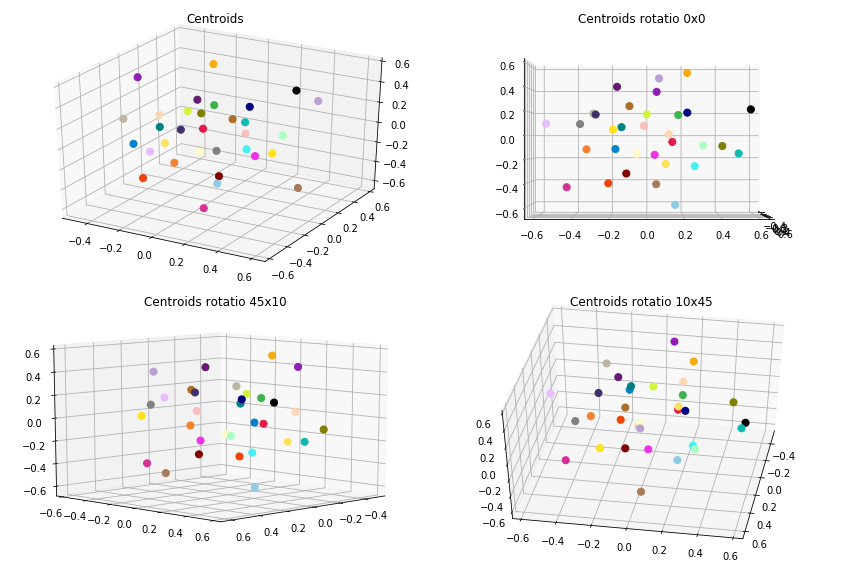

In [16]:
mds = MDS(
    n_components=3,
    n_init=5,
    max_iter=500,
    random_state=0,
    n_jobs=-1
)
X_cnt = mds.fit_transform(centroids)

plt.figure(figsize=(12, 8))
ax = plt.subplot(2, 2, 1, projection='3d')
plt.title("Centroids")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=colors_, alpha=1, s=50)
ax = plt.subplot(2, 2, 2, projection='3d')
plt.title("Centroids rotatio 0x0")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=colors_, alpha=1, s=50)
ax.view_init(0, 0)
ax = plt.subplot(2, 2, 3, projection='3d')
plt.title("Centroids rotatio 45x10")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=colors_, alpha=1, s=50)
ax.view_init(10, 45)
ax = plt.subplot(2, 2, 4, projection='3d')
plt.title("Centroids rotatio 10x45")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=colors_, alpha=1, s=50)
ax.view_init(45, 10)
plt.tight_layout()
plt.show()

### Clusterização dos dados de Teste

Por fim, realizada a clusterização dos dados de teste e a apresentação das 8 primeiras frases do conjunto de teste juntamente com outras duas frases do cluster ao qual foi identificado como o melhor.

In [17]:
Xtest = X_test.to_numpy()
for i, xt in enumerate(XT[:8]):
    clt = kclusterer.classify(xt)
    print("*", Xtest[i])
    for frase in utils.shuffle(df[df["cluster"] == clt].to_numpy())[:2]:
        print("  - ", frase[0])
    print("-" * 20)

* Se eu ativar roaming agora, já posso utilizar?
  -  Qual é a taxa de roaming para a Internet em Dubai?
  -  quais os serviços que podem ser resolvidos pelo bot?
--------------------
* Fui assaltado, preciso acionar seguro.
  -  As chamadas internacionais estão incluídas no meu plano?
  -  Qual é o procedimento para incluir um seguro para o meu telefone?
--------------------
* Estou bastante cansado do meu telefone existente e gostaria de saber quando eu vou ser elegível para sua atualização?
  -  Comprei um celular através da Amazon, como posso adicioná-lo à minha conta?
  -  Eu gostaria de comprar um plano somente
--------------------
* Oi, como posso ativar o encaminhamento de chamada no meu plano?
  -  Quanto me custará por minuto para chamar minha tia na Austrália?
  -  Eu quero ativar o identificador de chamadas.
--------------------
* Eu não consigo acessar meu email
  -  estou sem acesso ao meu endereco eletronico
  -  o email não esta no spam
--------------------
* Estou indo

### Métricas

Abaixo são apresentadas métricas para demonstrar o quanto a clusterização parece funcionar.

In [18]:
hom, compl, v_measure = homogeneity_completeness_v_measure(y_test, [kclusterer.classify(xt) for xt in XT])
silh = silhouette_score(XT, labels=[kclusterer.classify(xt) for xt in XT], metric="cosine", random_state=0)

print("Homogeneidade    : ", np.round(hom, 3))
print("Completude       : ", np.round(compl, 3))
print("V-Measure        : ", np.round(v_measure, 3))
print("Silhouette       : ", np.round(silh, 3))

Homogeneidade    :  0.67
Completude       :  0.716
V-Measure        :  0.692
Silhouette       :  0.058


In [19]:
def multi_kmeans(Xtf, k):
    error = True
    while error:
        try:
            initial_means = utils.shuffle(Xtf, n_samples=k).tolist()
            kclusterer_ = KMeansClusterer(
                k,
                initial_means=initial_means,
                distance=cosine_distance,
                avoid_empty_clusters=True
            )
            assigned_clusters = kclusterer_.cluster(Xtf, assign_clusters=True)
            error = False
        except:
            pass
    hom, compl, v_measure = homogeneity_completeness_v_measure(y_train, assigned_clusters)
    silh = silhouette_score(Xtf, labels=assigned_clusters, metric="cosine", random_state=0)
    return {"K": k, "HOM": hom, "COMPL": compl, "VM": v_measure, "SILH": silh}

clusterizacao = []
with ProcessPoolExecutor(max_workers=cpu_max) as exc:
    results = list(exc.map(partial(multi_kmeans, X), range(kmin, kmax), chunksize=10))
    for r in results:   
        clusterizacao.append({
            "Qtd. Cluster": r["K"],
            "Homogeneity": np.round(r["HOM"], 3),
            "Completeness": np.round(r["COMPL"], 3),
            "V-Measure": np.round(r["VM"], 3),
            "Silhouette": np.round(r["SILH"], 3)
        })

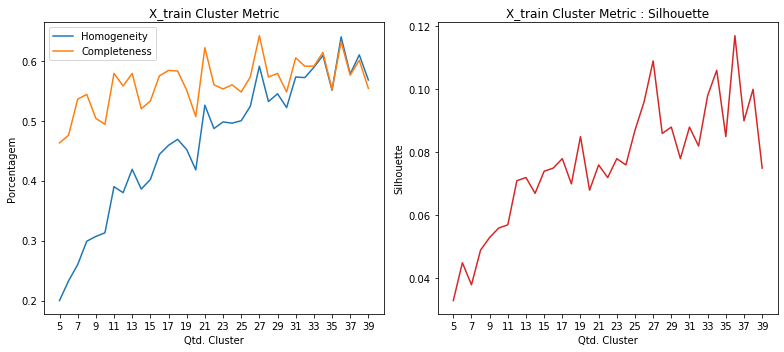

In [20]:
df_cluster = pd.DataFrame(clusterizacao, columns=["Qtd. Cluster", "Homogeneity", "Completeness", "Silhouette"])

plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.plot(df_cluster["Qtd. Cluster"], df_cluster["Homogeneity"], label="Homogeneity")
plt.plot(df_cluster["Qtd. Cluster"], df_cluster["Completeness"], label="Completeness")
plt.xticks(range(kmin, kmax, 2))
plt.title("X_train Cluster Metric")
plt.xlabel("Qtd. Cluster")
plt.ylabel("Porcentagem")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("")
plt.plot(df_cluster["Qtd. Cluster"], df_cluster["Silhouette"], c="C3")
plt.xticks(range(kmin, kmax, 2))
plt.title("X_train Cluster Metric : Silhouette")
plt.xlabel("Qtd. Cluster")
plt.ylabel("Silhouette")
plt.tight_layout()
plt.show()

### HDBSCAN no espaço dos dados

In [21]:
clusterer_ = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1, metric="precomputed", gen_min_span_tree=True)
assigned_clusters = clusterer_.fit_predict(pairwise_distances(X.astype(np.float64), metric="cosine"))
assigned_clusters = join_cluster(X, assigned_clusters)
qtd_cluster = len(list(set(assigned_clusters)))

docs = np.asarray(X_train)

info = []
frases = []
for i in range(qtd_cluster):
    idx = np.where(assigned_clusters == i)[0]
    for doc in docs[idx]:
        frases.append([doc, i])
    info.append([i, len(docs[idx])])

df = pd.DataFrame(frases, columns=["perguntas", "cluster"])
df_inf = pd.DataFrame(np.c_[[f"C{i}" for i in range(qtd_cluster)], np.asarray(info)[:, 1]])
print("Frases por cluster:")
data = []
for i in range(qtd_cluster):
    T = df.to_numpy()
    data += utils.shuffle(T[T[:, 1] == i], n_samples=3).tolist()
df = pd.DataFrame(data, columns=["title", "cluster"])
display(HTML(df.sort_values(by=["cluster"]).to_html(index=False)))

print("-" * 20)
print("Documentos por cluster:")
display(HTML(df_inf.to_html(index=False, header=False)))

Frases por cluster:


title,cluster
Quero informações sobre fazer ligações internacionais de casa,0
Preciso desconectar uma das minhas linhas telefônicas. Posso fazer isso por telefone?,0
"Logo precisarei fazer várias ligações internacionais do meu país. Onde posso encontrar, ou como posso ter uma lista completa com todos os preços possíveis indicados?",0
tem como renovar um certificado digital emitido?,1
onde consigo mais informações sobre a emição / manutenção de certificados digitais emitidos pela empresa?,1
Solicitação de certificado digital,1
posso acessar meu endereço eletrônico via thunderbird ou outlook?,2
consigo criar um endereço eletrônico de email institucional?,2
Eu preciso criar um email institucional,2
Existe uma loja local que poderia ativar o meu telefone pré-pago?,3


--------------------
Documentos por cluster:


C0,7
C1,12
C2,5
C3,5
C4,6
C5,5
C6,8
C7,7
C8,9
C9,23
C10,9


### Topologia dos dados de treinamento usando MDS

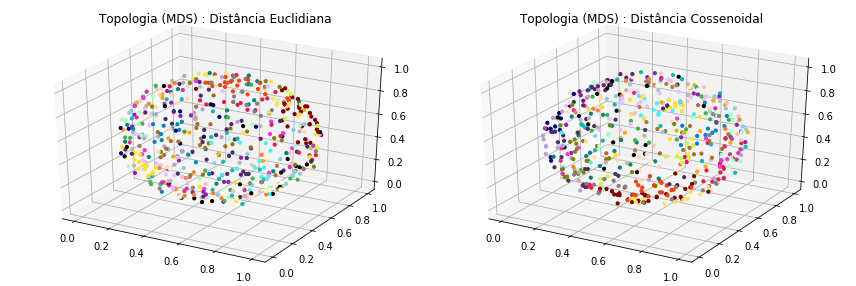

In [22]:
X_cnt = MDS(
    n_components=3,
    n_init=5,
    max_iter=500,
    random_state=0,
    n_jobs=-1
).fit_transform(X.astype(np.float64))
X_cnt = MinMaxScaler().fit_transform(X_cnt)

X_cnt2 = MDS(
    n_components=3,
    n_init=5,
    max_iter=500,
    dissimilarity="precomputed",
    random_state=0
).fit_transform(pairwise_distances(X.astype(np.float64), metric="cosine"))
X_cnt2 = MinMaxScaler().fit_transform(X_cnt2)

c_y_train, c_y_cluster = make_colors(y_train, y_train, colors)

plt.figure(figsize=(12, 8))
ax = plt.subplot(2, 2, 1, projection='3d')
plt.title("Topologia (MDS) : Distância Euclidiana")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=c_y_train, alpha=1, s=10)
ax = plt.subplot(2, 2, 2, projection='3d')
plt.title("Topologia (MDS) : Distância Cossenoidal")
ax.scatter(X_cnt2[:, 0], X_cnt2[:, 1], X_cnt2[:, 2], c=c_y_cluster, alpha=1, s=10)
plt.tight_layout()
plt.show()

## **HDBSCAN**

 - [How HDBSCAN Works](https://nbviewer.jupyter.org/github/scikit-learn-contrib/hdbscan/blob/master/notebooks/How%20HDBSCAN%20Works.ipynb)
 - [hdbscan github implementation](https://github.com/scikit-learn-contrib/hdbscan)
 - [Density-Based Clustering Based on Hierarchical Density Estimates](https://link.springer.com/chapter/10.1007/978-3-642-37456-2_14)

---

## **t-SNE + HDBSCAN**

In [23]:
def calculate_tsne(X, perp):
    lr = int(np.mean(np.random.randint(10, 300, 5)))
    angle = np.max(np.round(np.random.uniform(0.5, 0.9, 5), 2))
    
    X_cnt_ = TSNE(
        n_components=3,
        init="pca",
        learning_rate=lr,
        perplexity=perp,
        angle=angle,
        metric="cosine",
        method="exact",
        n_iter=5000,
        n_iter_without_progress=1000,
        random_state=0
    ).fit_transform(X)
    X_cnt_ = MinMaxScaler().fit_transform(X_cnt_)
    
    clusterer_ = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1, metric="precomputed", gen_min_span_tree=True)
    cluster_labels_ = clusterer_.fit_predict(pairwise_distances(X_cnt_.astype(np.float64), metric="cosine"))
    cluster_labels_ = join_cluster(X_cnt_, cluster_labels_)   

    hom, compl, v_measure = homogeneity_completeness_v_measure(y_train, cluster_labels_)
    silh = silhouette_score(X_cnt_, labels=cluster_labels_, metric="cosine", random_state=0)
    return {
        "POINTS": X_cnt_,
        "CLUSTERS": cluster_labels_,
        "ANGLE": angle,
        "LEARNING_RATE": lr,
        "PERP": perp,
        "HOM": hom,
        "COMPL": compl,
        "VMEN": v_measure,
        "SILH": silh
    }

clusterizacao = []
with ProcessPoolExecutor(max_workers=cpu_max) as exc:
    results = list(exc.map(partial(calculate_tsne, X), range(5, 61, 1), chunksize=10))
    for r in results:   
        clusterizacao.append({
            "Points": r["POINTS"],
            "Clusters": r["CLUSTERS"],
            "Perplexity": r["PERP"],
            "Learning Rate": r["LEARNING_RATE"],
            "Angle": r["ANGLE"],
            "Homogeneity": np.round(r["HOM"], 3),
            "Completeness": np.round(r["COMPL"], 3),
            "V-Measure": np.round(r["VMEN"], 3),
            "Silhouette": np.round(r["SILH"], 3)
        })

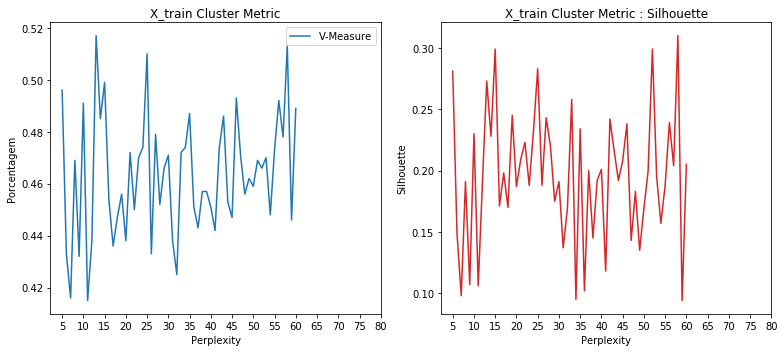

In [24]:
df_cluster = pd.DataFrame(clusterizacao, columns=["Perplexity", "Learning Rate", "Angle", "V-Measure", "Silhouette"]).sort_values(by=["Perplexity"])

plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.plot(df_cluster["Perplexity"], df_cluster["V-Measure"], label="V-Measure")
plt.xticks(range(5, 81, 5))
plt.title("X_train Cluster Metric")
plt.xlabel("Perplexity")
plt.ylabel("Porcentagem")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("")
plt.plot(df_cluster["Perplexity"], df_cluster["Silhouette"], c="C3")
plt.xticks(range(5, 81, 5))
plt.title("X_train Cluster Metric : Silhouette")
plt.xlabel("Perplexity")
plt.ylabel("Silhouette")
plt.tight_layout()
plt.show()

In [25]:
perp, lr, angle = df_cluster[df_cluster["Silhouette"] == np.max(df_cluster["Silhouette"])][["Perplexity", "Learning Rate", "Angle"]].to_numpy()[0]
df_cluster.sort_values(by=["Silhouette"], ascending=False)[:25]

,Perplexity,Learning Rate,Angle,V-Measure,Silhouette
53,58,134,0.77,0.513,0.310
47,52,209,0.87,0.466,0.299
10,15,148,0.90,0.499,0.299
20,25,148,0.90,0.510,0.283
0,5,148,0.90,0.496,0.281
8,13,94,0.89,0.517,0.273
28,33,94,0.89,0.472,0.258
14,19,189,0.85,0.456,0.245
22,27,204,0.87,0.479,0.243
37,42,187,0.87,0.474,0.242


Homogeneidade    :  0.526
Completude       :  0.501
V-Measure        :  0.513
Silhouette       :  0.31


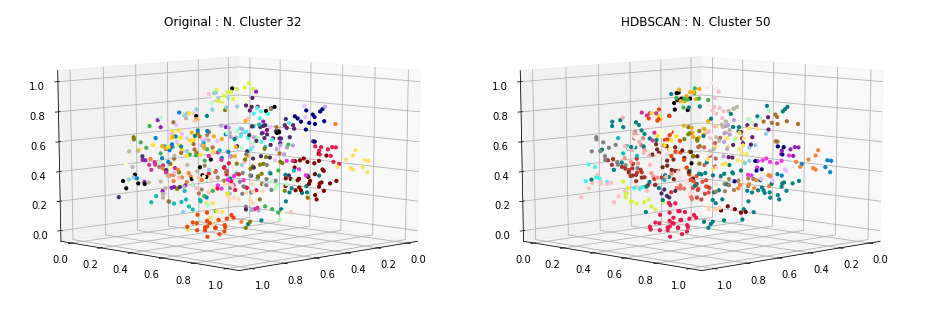

In [26]:
X_cnt = TSNE(
    n_components=3,
    init="pca",
    learning_rate=lr,
    perplexity=perp,
    angle=angle,
    metric="cosine",
    method="exact",
    n_iter=5000,
    n_iter_without_progress=1000,
    random_state=0
).fit_transform(X)
X_cnt = MinMaxScaler().fit_transform(X_cnt)

clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1, metric="precomputed", gen_min_span_tree=True)
cluster_labels = clusterer.fit_predict(pairwise_distances(X_cnt.astype(np.float64), metric="cosine"))
cluster_labels = join_cluster(X_cnt, cluster_labels)
c_y_train, c_y_cluster = make_colors(y_train, cluster_labels, colors)

hom, compl, v_measure = homogeneity_completeness_v_measure(y_train, cluster_labels)
silh = silhouette_score(X_cnt, labels=cluster_labels, metric="cosine", random_state=0)

print("Homogeneidade    : ", np.round(hom, 3))
print("Completude       : ", np.round(compl, 3))
print("V-Measure        : ", np.round(v_measure, 3))
print("Silhouette       : ", np.round(silh, 3))

plt.figure(figsize=(13, 9))
ax = plt.subplot(2, 2, 1, projection='3d')
plt.title(f"Original : N. Cluster {len(set(y_train))}")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=c_y_train, alpha=1, s=10)
ax.view_init(10, 45)
ax = plt.subplot(2, 2, 2, projection='3d')
plt.title(f"HDBSCAN : N. Cluster {len(set(cluster_labels))}")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=c_y_cluster, alpha=1, s=10)
ax.view_init(10, 45)
plt.tight_layout()
plt.show()

In [27]:
qtd_clusters = len(set(cluster_labels))
docs = np.asarray(X_train)

info = []
frases = []
for i in range(qtd_clusters):
    idx = np.where(cluster_labels == i)[0]
    for doc in docs[idx]:
        frases.append([doc, i])
    info.append([i, len(docs[idx])])

df = pd.DataFrame(frases, columns=["perguntas", "cluster"])
df_inf = pd.DataFrame(np.c_[[f"C{i}" for i in range(qtd_clusters)], np.asarray(info)[:, 1]])

print("Frases por cluster:")
data = []
for i in range(qtd_clusters):
    T = df.to_numpy()
    data += utils.shuffle(T[T[:, 1] == i], n_samples=3).tolist()
df = pd.DataFrame(data, columns=["title", "cluster"])
display(HTML(df.sort_values(by=["cluster"]).to_html(index=False)))

print("-" * 20)
print("Documentos por cluster:")
display(HTML(df_inf.to_html(index=False, header=False)))

Frases por cluster:


title,cluster
acessar remotamente os sistemas da empresa da minha casa,0
como acessar wifi da empresa?,0
como acessar os sistemas da empresa de casa,0
Quando minha conta vai ser elegível para um dispositivo atualizado,1
Por favor me diga quando eu vou ser elegível para minha próxima atualização do dispositivo.,1
Quando dentro do contrato sou elegivel para atualizar meu atual aparelho?,1
Eu estou pagando pela cobertura da LTE. Eu não posso usar isso? Espero que isso seja refletido como um desconto na minha conta até que eu possa usar o que eu pago.,2
O que vai custar menos ficar no meu plano atual ou mudar para o novo?,2
Por favor me avise se eu vou poder ficar com o meu número de telefone atual quando mudar de fornecedores,2
how to configure vpn?,3


--------------------
Documentos por cluster:


C0,33
C1,8
C2,7
C3,6
C4,15
C5,5
C6,9
C7,11
C8,13
C9,13
C10,88


---

## **Spectral Embedding + HDBSCAN**

In [28]:
def calculate_spec_emb(X, gamma):
    X_cnt_ = SpectralEmbedding(
        n_components=3,
        affinity="rbf",
        gamma=gamma,
        n_neighbors=5,
        random_state=0
    ).fit_transform(X)
    X_cnt_ = MinMaxScaler().fit_transform(X_cnt_)
    
    clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1, metric="precomputed", gen_min_span_tree=True)
    cluster_labels_ = clusterer.fit_predict(pairwise_distances(X_cnt_.astype(np.float64), metric="cosine"))
    cluster_labels_ = join_cluster(X_cnt_, cluster_labels_)
    
    hom, compl, v_measure = homogeneity_completeness_v_measure(y_train, cluster_labels_)
    silh = silhouette_score(X_cnt_, labels=cluster_labels_, metric="cosine", random_state=0)
    return {
        "POINTS": X_cnt_,
        "CLUSTERS": cluster_labels_,
        "GAMMA": gamma,
        "HOM": hom,
        "COMPL": compl,
        "VMEN": v_measure,
        "SILH": silh
    }

clusterizacao_sp = []
with ProcessPoolExecutor(max_workers=cpu_max) as exc:
    results = list(exc.map(partial(calculate_spec_emb, X), np.round(np.random.uniform(0.2, 0.9, 20), 2), chunksize=10))
    for r in results:   
        clusterizacao_sp.append({
            "Points": r["POINTS"],
            "Clusters": r["CLUSTERS"],
            "Gamma": r["GAMMA"],
            "Homogeneity": np.round(r["HOM"], 3),
            "Completeness": np.round(r["COMPL"], 3),
            "V-Measure": np.round(r["VMEN"], 3),
            "Silhouette": np.round(r["SILH"], 3)
        })

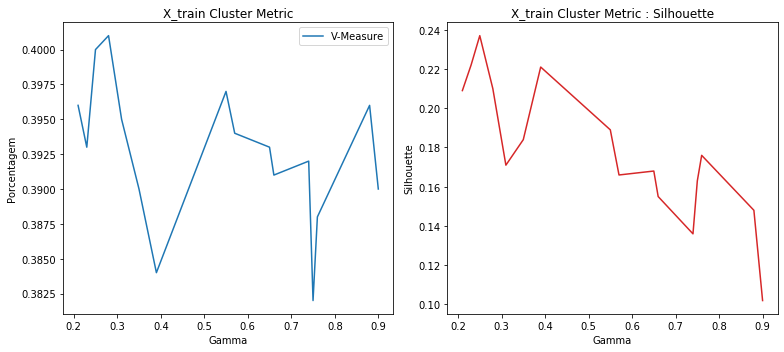

In [29]:
df_cluster_sp = pd.DataFrame(clusterizacao_sp, columns=["Gamma", "V-Measure", "Silhouette"]).sort_values(by=["Gamma"])

plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.plot(df_cluster_sp["Gamma"], df_cluster_sp["V-Measure"], label="V-Measure")
plt.title("X_train Cluster Metric")
plt.xlabel("Gamma")
plt.ylabel("Porcentagem")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("")
plt.plot(df_cluster_sp["Gamma"], df_cluster_sp["Silhouette"], c="C3")
plt.title("X_train Cluster Metric : Silhouette")
plt.xlabel("Gamma")
plt.ylabel("Silhouette")
plt.tight_layout()
plt.show()

In [30]:
gamma = df_cluster_sp[df_cluster_sp["Silhouette"] == np.max(df_cluster_sp["Silhouette"])]["Gamma"].to_numpy()[0]
df_cluster_sp.sort_values(by=["Silhouette"], ascending=False)[:25]

,Gamma,V-Measure,Silhouette
4,0.25,0.400,0.237
14,0.25,0.400,0.237
18,0.23,0.393,0.222
12,0.39,0.384,0.221
10,0.28,0.401,0.210
15,0.21,0.396,0.209
19,0.55,0.397,0.189
5,0.55,0.397,0.189
3,0.35,0.390,0.184
13,0.76,0.388,0.176


Homogeneidade    :  0.402
Completude       :  0.398
V-Measure        :  0.4
Silhouette       :  0.237


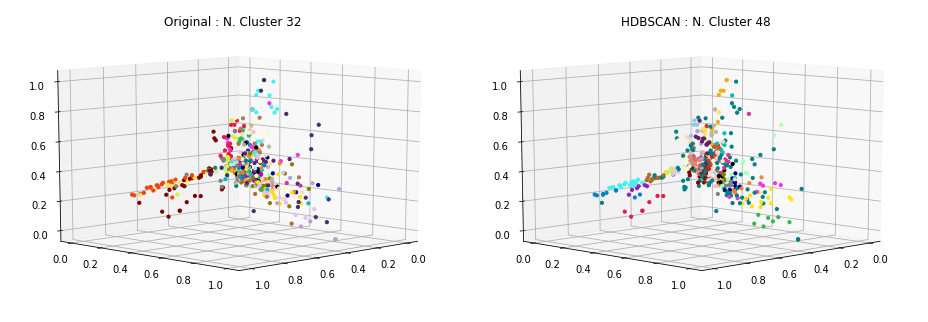

In [31]:
X_cnt = SpectralEmbedding(
    n_components=3,
    affinity="rbf",
    gamma=gamma,
    n_neighbors=5,
    random_state=0
).fit_transform(X)
X_cnt = MinMaxScaler().fit_transform(X_cnt)

clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1, metric="precomputed", gen_min_span_tree=True)
cluster_labels = clusterer.fit_predict(pairwise_distances(X_cnt.astype(np.float64), metric="cosine"))
cluster_labels = join_cluster(X_cnt, cluster_labels)
c_y_train, c_y_cluster = make_colors(y_train, cluster_labels, colors)

# clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
# cluster_labels = clusterer.fit_predict(X_cnt)

hom, compl, v_measure = homogeneity_completeness_v_measure(y_train, cluster_labels)
silh = silhouette_score(X_cnt, labels=cluster_labels, metric="cosine", random_state=0)
# silh = silhouette_score(X_cnt, labels=cluster_labels, random_state=0)

print("Homogeneidade    : ", np.round(hom, 3))
print("Completude       : ", np.round(compl, 3))
print("V-Measure        : ", np.round(v_measure, 3))
print("Silhouette       : ", np.round(silh, 3))

plt.figure(figsize=(13, 9))
ax = plt.subplot(2, 2, 1, projection='3d')
plt.title(f"Original : N. Cluster {len(set(y_train))}")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=c_y_train, alpha=1, s=10)
ax.view_init(10, 45)
ax = plt.subplot(2, 2, 2, projection='3d')
plt.title(f"HDBSCAN : N. Cluster {len(set(cluster_labels))}")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=c_y_cluster, alpha=1, s=10)
ax.view_init(10, 45)
plt.tight_layout()
plt.show()

---

## **MDS + HDBSCAN**

In [32]:
def calculate_mds(X, init):
    iteration = np.random.randint(500, 5000)
    X_cnt_ = MDS(
        n_components=3,
        n_init=init,
        max_iter=iteration,
        dissimilarity="precomputed",
        random_state=0
    ).fit_transform(pairwise_distances(X.astype(np.float64), metric="cosine"))
    X_cnt_ = MinMaxScaler().fit_transform(X_cnt_)
    
    clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1, metric="precomputed", gen_min_span_tree=True)
    cluster_labels_ = clusterer.fit_predict(pairwise_distances(X_cnt_.astype(np.float64), metric="cosine"))
    cluster_labels_ = join_cluster(X_cnt_, cluster_labels_)
    
    hom, compl, v_measure = homogeneity_completeness_v_measure(y_train, cluster_labels_)
    silh = silhouette_score(X_cnt_, labels=cluster_labels_, metric="cosine", random_state=0)
    return {
        "POINTS": X_cnt_,
        "CLUSTERS": cluster_labels_,
        "INIT": init,
        "ITER": iteration,
        "HOM": hom,
        "COMPL": compl,
        "VMEN": v_measure,
        "SILH": silh
    }

clusterizacao_sp = []
with ProcessPoolExecutor(max_workers=cpu_max) as exc:
    results = list(exc.map(partial(calculate_mds, X), range(5, 30), chunksize=10))
    for r in results:   
        clusterizacao_sp.append({
            "Points": r["POINTS"],
            "Clusters": r["CLUSTERS"],
            "N_Init": r["INIT"],
            "Iterações": r["ITER"],
            "Homogeneity": np.round(r["HOM"], 3),
            "Completeness": np.round(r["COMPL"], 3),
            "V-Measure": np.round(r["VMEN"], 3),
            "Silhouette": np.round(r["SILH"], 3)
        })

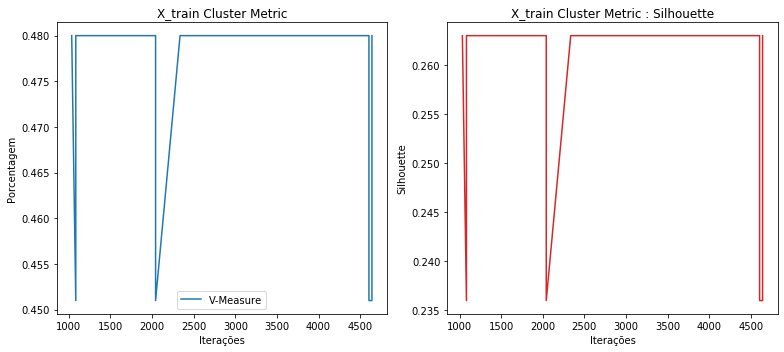

In [33]:
df_cluster_sp = pd.DataFrame(clusterizacao_sp, columns=["Iterações", "N_Init", "V-Measure", "Silhouette"]).sort_values(by=["Iterações"])

plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.plot(df_cluster_sp["Iterações"], df_cluster_sp["V-Measure"], label="V-Measure")
plt.title("X_train Cluster Metric")
plt.xlabel("Iterações")
plt.ylabel("Porcentagem")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("")
plt.plot(df_cluster_sp["Iterações"], df_cluster_sp["Silhouette"], c="C3")
plt.title("X_train Cluster Metric : Silhouette")
plt.xlabel("Iterações")
plt.ylabel("Silhouette")
plt.tight_layout()
plt.show()

In [34]:
iterations, init = df_cluster_sp[df_cluster_sp["Silhouette"] == np.max(df_cluster_sp["Silhouette"])][["Iterações", "N_Init"]].to_numpy()[0]
df_cluster_sp.sort_values(by=["Silhouette"], ascending=False)[:25]

,Iterações,N_Init,V-Measure,Silhouette
19,1034,24,0.480,0.263
9,1034,14,0.480,0.263
22,4642,27,0.480,0.263
13,4606,18,0.480,0.263
23,4606,28,0.480,0.263
8,4021,13,0.480,0.263
18,4021,23,0.480,0.263
5,2643,10,0.480,0.263
15,2643,20,0.480,0.263
16,2519,21,0.480,0.263


Homogeneidade    :  0.488
Completude       :  0.473
V-Measure        :  0.48
Silhouette       :  0.263


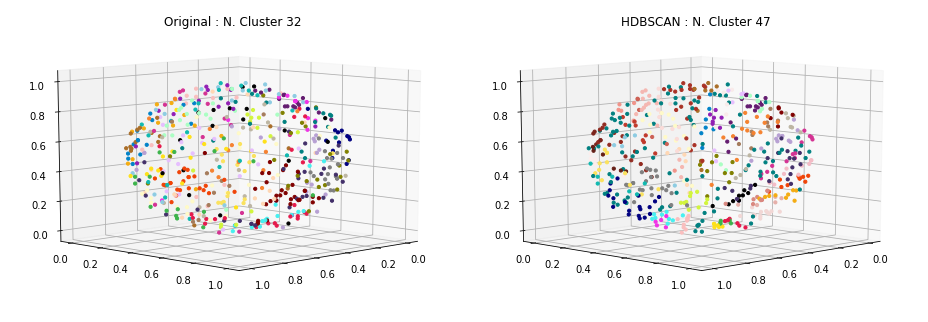

In [35]:
X_cnt = MDS(
    n_components=3,
    n_init=init,
    max_iter=iterations,
    dissimilarity="precomputed",
    random_state=0
).fit_transform(pairwise_distances(X.astype(np.float64), metric="cosine"))
X_cnt = MinMaxScaler().fit_transform(X_cnt)

clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1, metric="precomputed", gen_min_span_tree=True)
cluster_labels = clusterer.fit_predict(pairwise_distances(X_cnt.astype(np.float64), metric="cosine"))
cluster_labels = join_cluster(X_cnt, cluster_labels)
c_y_train, c_y_cluster = make_colors(y_train, cluster_labels, colors)

# clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
# cluster_labels = clusterer.fit_predict(X_cnt)

hom, compl, v_measure = homogeneity_completeness_v_measure(y_train, cluster_labels)
silh = silhouette_score(X_cnt, labels=cluster_labels, metric="cosine", random_state=0)
# silh = silhouette_score(X_cnt, labels=cluster_labels, random_state=0)

print("Homogeneidade    : ", np.round(hom, 3))
print("Completude       : ", np.round(compl, 3))
print("V-Measure        : ", np.round(v_measure, 3))
print("Silhouette       : ", np.round(silh, 3))

plt.figure(figsize=(13, 9))
ax = plt.subplot(2, 2, 1, projection='3d')
plt.title(f"Original : N. Cluster {len(set(y_train))}")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=c_y_train, alpha=1, s=10)
ax.view_init(10, 45)
ax = plt.subplot(2, 2, 2, projection='3d')
plt.title(f"HDBSCAN : N. Cluster {len(set(cluster_labels))}")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=c_y_cluster, alpha=1, s=10)
ax.view_init(10, 45)
plt.tight_layout()
plt.show()